#### <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [50]:
path = 'C:/Users/charg/Desktop/Coding/Python/loan.xlsx'

### Load Data From CSV File


In [51]:
df = pd.read_excel(path)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [ ]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

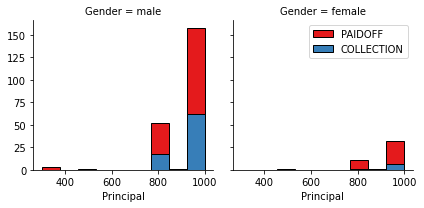

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

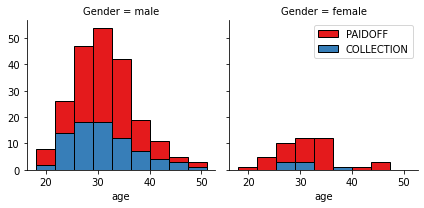

In [11]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


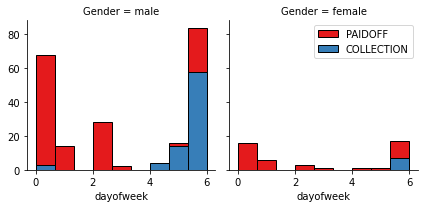

In [8]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [9]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [10]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [11]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [12]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [13]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [14]:
Feature = df[['Principal','terms','age','Gender']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,1,0,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,0,0,1
4,1000,30,29,0,0,0,1


### Feature Selection


Let's define feature sets, X:


In [15]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,Bechalor,High School or Below,college
0,1000,30,45,0,0,1,0
1,1000,30,33,1,1,0,0
2,1000,15,27,0,0,0,1
3,1000,30,28,1,0,0,1
4,1000,30,29,0,0,0,1


What are our lables?


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -0.38170062,
         1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177,  2.61985426,
        -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177, -0.38170062,
        -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004, -0.38170062,
        -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 7) (276,)
Test set: (70, 7) (70,)


### Training

In [19]:
from sklearn.neighbors import KNeighborsClassifier
k = 4
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

### Predicting

In [20]:
yhat = neigh.predict(X_test)   #Using the model to predict the first values of the test set
yhat[0:5]

array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

### Accuracy Evaluation

In [21]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7463768115942029
Test set Accuracy:  0.6714285714285714


### Setting up to test the accuracy for other Ks

In [28]:
Ks = 10              #we can change this number to test more K values
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):               #loops through each K value to train and predict. results plotted below
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.65714286, 0.55714286, 0.71428571, 0.67142857, 0.77142857,
       0.72857143, 0.74285714, 0.7       , 0.72857143])

### Plotting our results

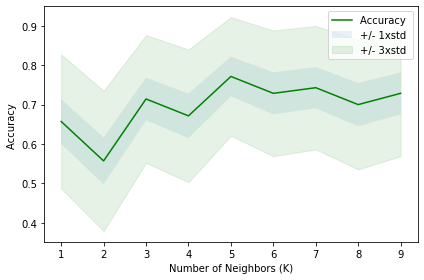

In [29]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

# From the chart below we can see a k of 5 will give us the highest accuracy. (finding 5 neighbors)

# Decision Tree


In [30]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

### Practice

In [31]:
print('Shape of X training set {}'.format(X_trainset.shape),'&',' Size of Y training set {}'.format(y_trainset.shape))
# Ensure that the dimensions of the X & Y match

Shape of X training set (242, 7) &  Size of Y training set (242,)


In [32]:
print('Shape of X training set {}'.format(X_testset.shape),'&',' Size of Y training set {}'.format(y_testset.shape))
# Same for Test set. ensure the dimensions match

Shape of X training set (104, 7) &  Size of Y training set (104,)


### Modeling

In [33]:
from sklearn.tree import DecisionTreeClassifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loanTree   # it shows the default parameters

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [34]:
loanTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Prediction

In [35]:
predTree = loanTree.predict(X_testset)

In [36]:
print(predTree [0:10]) #prediction
print(y_testset [0:10]) #Actual Dataset

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']


### Evaluation

In [37]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.7403846153846154


In [38]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

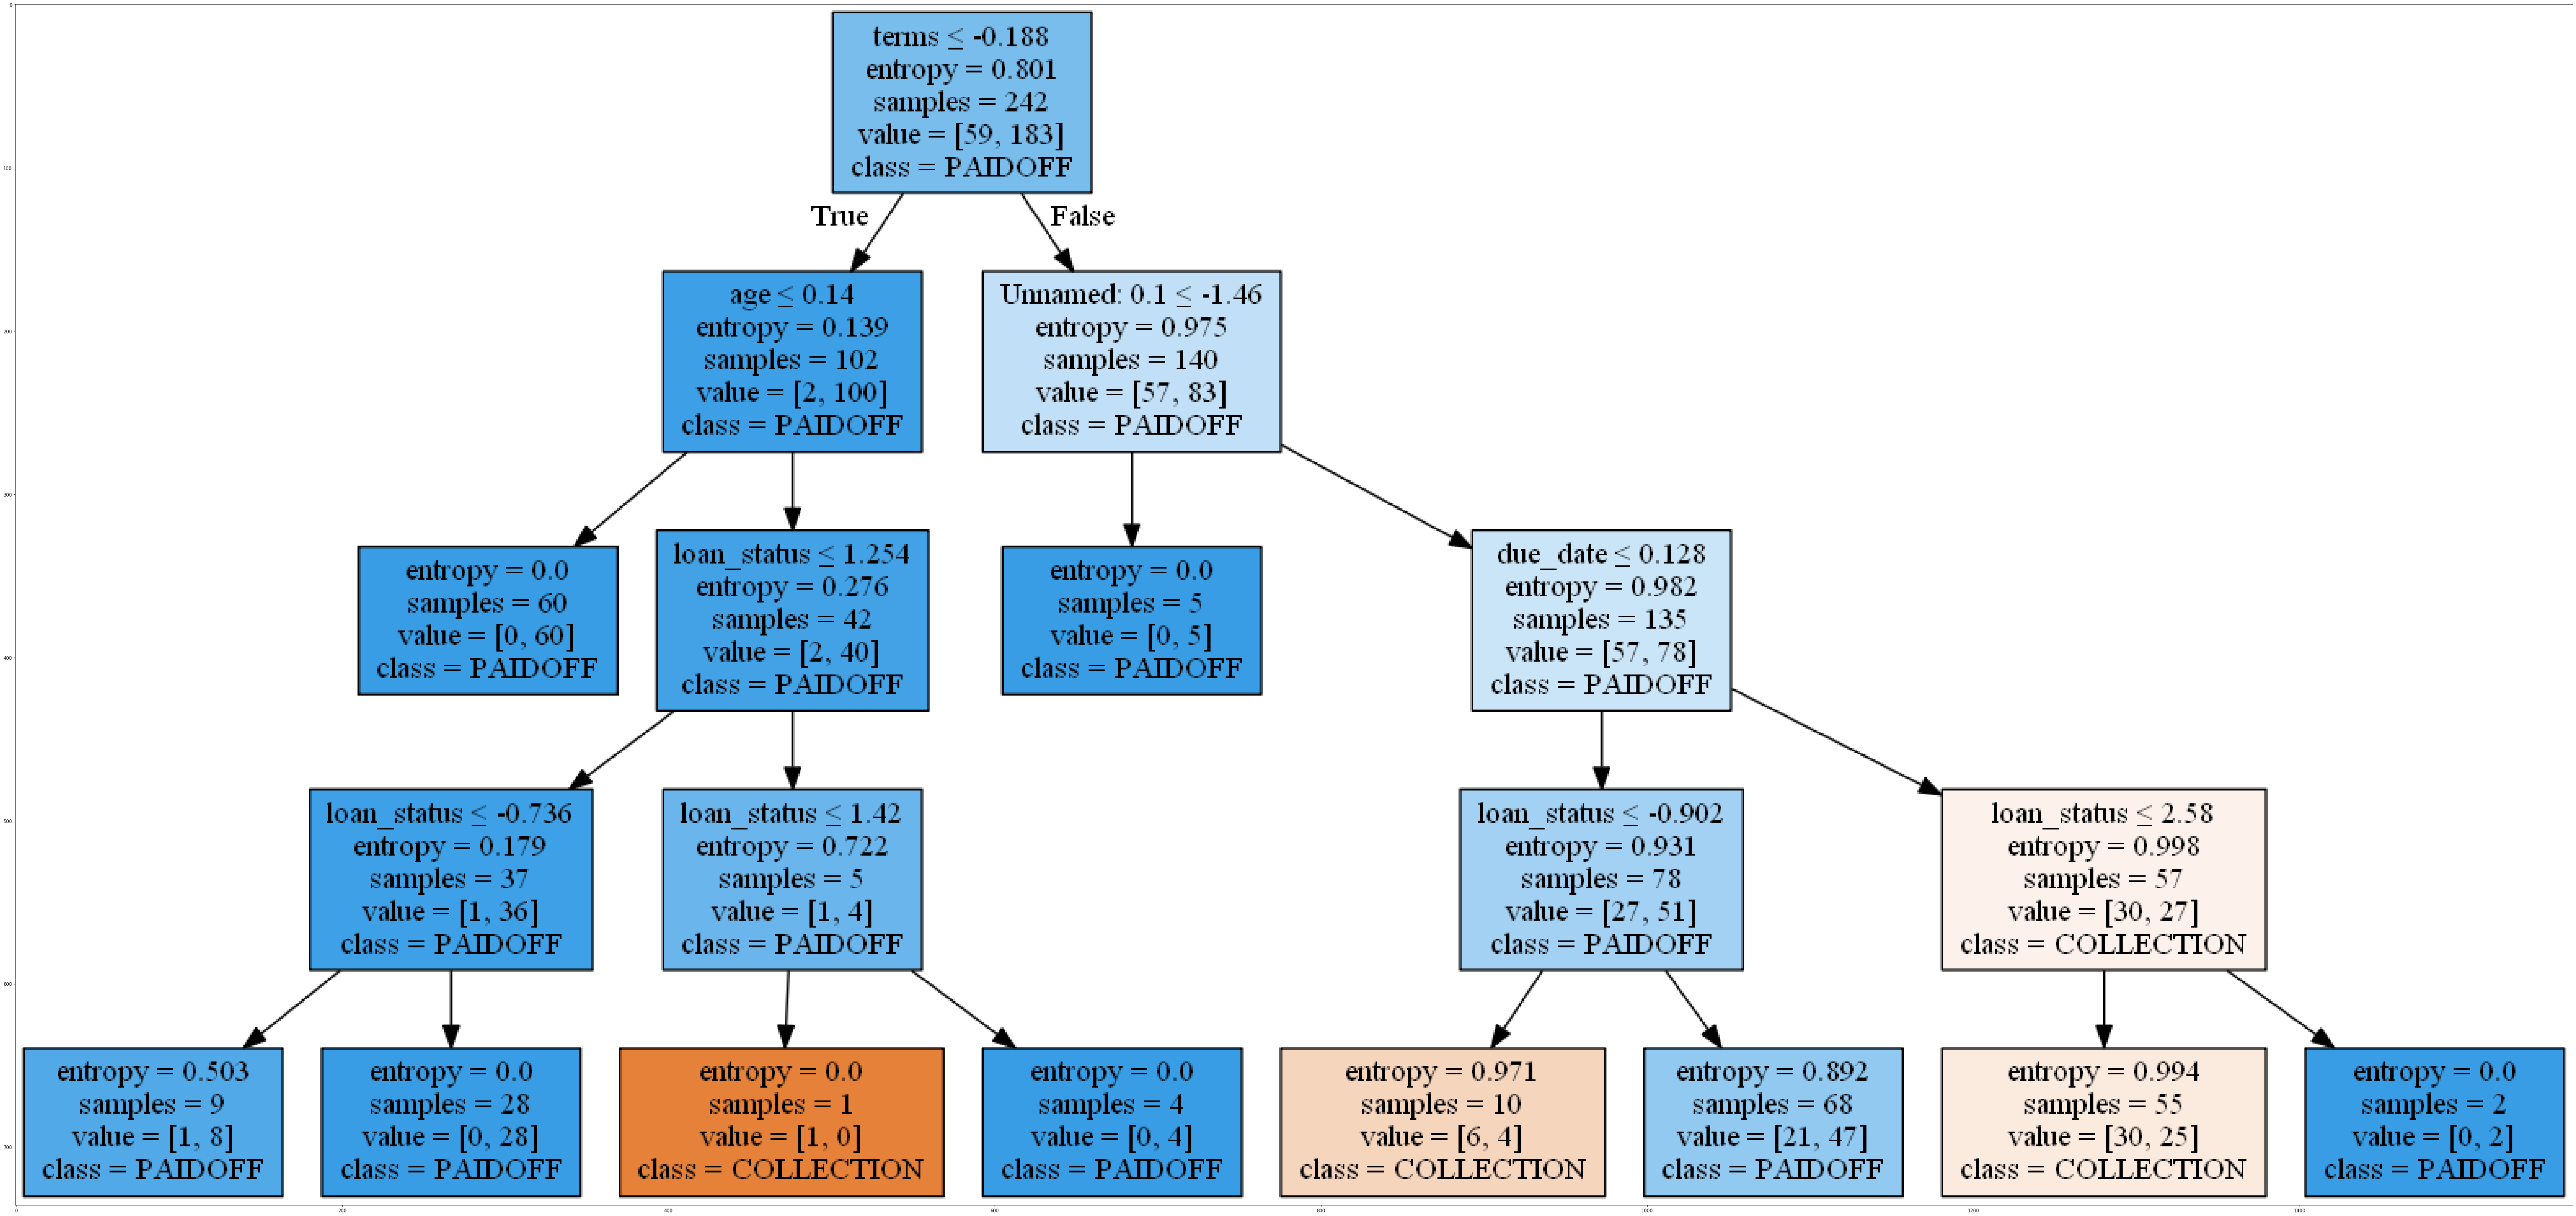

In [64]:
dot_data = StringIO()
filename = "loantree.png"
featureNames = df.columns[0:8]   #Number of columns
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [39]:
import pandas as pd
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dayofweek                  int64
weekend                    int64
dtype: object

### Preparing data

In [41]:
df.drop(["Unnamed: 0"], axis=1, inplace = True)
df.drop(["Unnamed: 0.1"], axis=1, inplace = True)
df['Gender'] = df['Gender'].astype('category')
df['Gender'] = df['Gender'].cat.codes
df['loan_status'] = df['loan_status'].astype('category')
df['loan_status'] = df['loan_status'].cat.codes
df['education'] = df['education'].astype('category')  #switching education to numerical values
df['education'] = df['education'].cat.codes      #converting categorical values from strings to numerical values
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1000,30,2016-09-08,2016-10-07,45,1,0,3,0
1,1,1000,30,2016-09-08,2016-10-07,33,0,1,3,0
2,1,1000,15,2016-09-08,2016-09-22,27,3,0,3,0
3,1,1000,30,2016-09-09,2016-10-08,28,3,1,4,1
4,1,1000,30,2016-09-09,2016-10-08,29,3,0,4,1


In [42]:
feature_df = df[['loan_status', 'Principal', 'terms', 'age', 'education', 'Gender']]
X = np.asarray(feature_df)
X[0:5]

array([[   1, 1000,   30,   45,    1,    0],
       [   1, 1000,   30,   33,    0,    1],
       [   1, 1000,   15,   27,    3,    0],
       [   1, 1000,   30,   28,    3,    1],
       [   1, 1000,   30,   29,    3,    0]], dtype=int64)

### Visualize the separation

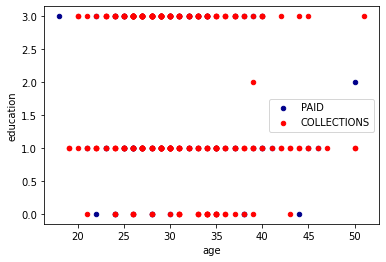

In [43]:
ax = df[df['loan_status'] == 0][0:300].plot(kind='scatter', x='age', y='education', color='DarkBlue', label='PAID');
df[df['loan_status'] == 1][0:300].plot(kind='scatter', x='age', y='education', color='red', label='COLLECTIONS', ax=ax);
plt.show()

### Train/Test Dataset

In [44]:
from sklearn.model_selection import train_test_split
y = df['loan_status'].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 6) (276,)
Test set: (70, 6) (70,)


### Modeling

In [45]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 1, 1], dtype=int8)

### Evaluation

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


C:\Users\charg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


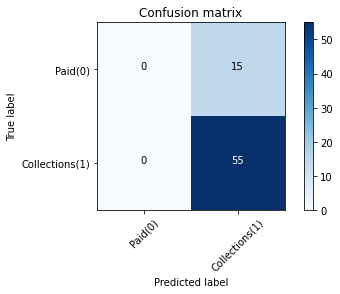

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid(0)','Collections(1)'],normalize= False,  title='Confusion matrix')

In [48]:
# F1 Score
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6914285714285714

# Logistic Regression


In [52]:
df.drop(["Unnamed: 0"], axis=1, inplace = True)
df.drop(["Unnamed: 0.1"], axis=1, inplace = True)
df['Gender'] = df['Gender'].astype('category')
df['Gender'] = df['Gender'].cat.codes
df['loan_status'] = df['loan_status'].astype('category')
df['loan_status'] = df['loan_status'].cat.codes
df['education'] = df['education'].astype('category')  #switching education to numerical values
df['education'] = df['education'].cat.codes      #converting categorical values from strings to numerical values
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1000,30,2016-09-08,2016-10-07,45,1,1
1,1,1000,30,2016-09-08,2016-10-07,33,0,0
2,1,1000,15,2016-09-08,2016-09-22,27,3,1
3,1,1000,30,2016-09-09,2016-10-08,28,3,0
4,1,1000,30,2016-09-09,2016-10-08,29,3,1


In [55]:
X = np.asarray(df[['Principal', 'terms', 'age', 'education', 'Gender']])
X[0:5]

array([[1000,   30,   45,    1,    1],
       [1000,   30,   33,    0,    0],
       [1000,   15,   27,    3,    1],
       [1000,   30,   28,    3,    0],
       [1000,   30,   29,    3,    1]], dtype=int64)

In [56]:
y = np.asarray(df['loan_status'])
y [0:5]

array([1, 1, 1, 1, 1], dtype=int8)

In [ ]:
from sklearn import preprocessing    #normalize data set
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

### Train/Test Dataset

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [59]:
yhat = LR.predict(X_test)
yhat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int8)

### Evaluation

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[55  0]
 [15  0]]


Confusion matrix, without normalization
[[55  0]
 [15  0]]


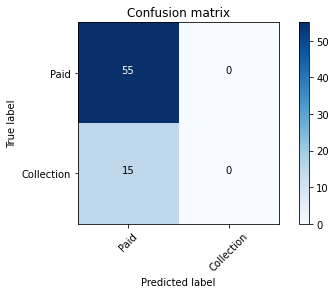

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paid','Collection'],normalize= False,  title='Confusion matrix')

In [64]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.31, 0.69],
       [0.23, 0.77],
       [0.2 , 0.8 ],
       [0.35, 0.65],
       [0.26, 0.74],
       [0.23, 0.77],
       [0.26, 0.74],
       [0.23, 0.77],
       [0.35, 0.65],
       [0.28, 0.72],
       [0.33, 0.67],
       [0.3 , 0.7 ],
       [0.31, 0.69],
       [0.33, 0.67],
       [0.13, 0.87],
       [0.19, 0.81],
       [0.38, 0.62],
       [0.2 , 0.8 ],
       [0.31, 0.69],
       [0.25, 0.75],
       [0.26, 0.74],
       [0.29, 0.71],
       [0.34, 0.66],
       [0.35, 0.65],
       [0.19, 0.81],
       [0.32, 0.68],
       [0.33, 0.67],
       [0.13, 0.87],
       [0.32, 0.68],
       [0.16, 0.84],
       [0.2 , 0.8 ],
       [0.32, 0.68],
       [0.25, 0.75],
       [0.26, 0.74],
       [0.2 , 0.8 ],
       [0.18, 0.82],
       [0.31, 0.69],
       [0.16, 0.84],
       [0.3 , 0.7 ],
       [0.21, 0.79],
       [0.33, 0.67],
       [0.26, 0.74],
       [0.16, 0.84],
       [0.32, 0.68],
       [0.21, 0.79],
       [0.33, 0.67],
       [0.21, 0.79],
       [0.3 ,

In [65]:
# Log Loss
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.555863882127041

In [66]:
# Jaccard index
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=0)

0.0

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
